In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import Callback

In [17]:
class CustomStoppingCallback(Callback):
    def __init__(self, target_loss=20, target_mae=3):
        super().__init__()
        self.target_loss = target_loss
        self.target_mae = target_mae

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        mae = logs.get('mae')
        
        if loss < self.target_loss and mae < self.target_mae:
            print(f"\nEpoch {epoch+1}: Loss < {self.target_loss} and MAE < {self.target_mae}, stopping training.")
            self.model.stop_training = True

In [18]:
# Load dataset
df = pd.read_csv("dataset/air_quality_data_fix.csv")

# Fitur (input): Konsentrasi polutan
features = df[["co", "no2", "o3", "pm10", "pm25", "so2"]]
target = df["universal_aqi"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [19]:
model = Sequential([
    Input(shape=(6,)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae', 'mse'])

custom_callback = CustomStoppingCallback(target_loss=5, target_mae=5)

In [21]:
# Latih model dengan callback
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[custom_callback],
    verbose=1
)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2750.9089 - mae: 48.4733 - mse: 2749.5090 - val_loss: 2639.7324 - val_mae: 47.4806 - val_mse: 2638.3440
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2610.3022 - mae: 46.8889 - mse: 2608.9116 - val_loss: 2312.4607 - val_mae: 43.9618 - val_mse: 2311.0535
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2160.8210 - mae: 42.0528 - mse: 2159.4006 - val_loss: 1546.6943 - val_mae: 34.9215 - val_mse: 1545.2194
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1302.8303 - mae: 31.3043 - mse: 1301.3318 - val_loss: 638.6804 - val_mae: 21.3120 - val_mse: 637.1063
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 494.9907 - mae: 18.5146 - mse: 493.3943 - val_loss: 163.1857 - val_mae: 10.6295 - val_mse: 161.5397
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 133.9111 - mae: 9.5702 - mse: 132.2573 - val_loss: 77.0427 - val_mae: 7.1876 - val_mse: 75.3787
Epoch 7/100
113/113 ━━━━

In [22]:
# Evaluasi model pada data uji
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=1)

# Cetak hasil evaluasi
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3352 - mae: 1.1549 - mse: 2.6135
Test Loss: 4.442044258117676, Test MAE: 1.1664947271347046, Test MSE: 2.7203001976013184


In [26]:
import json

scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}

with open("scaler.json", "w") as f:
    json.dump(scaler_params, f)

print("Scaler has been saved to 'scaler.json'")

Scaler has been saved to 'scaler.json'


In [24]:
model.export('LinearSaveModel')

INFO:tensorflow:Assets written to: LinearSaveModel\assets


INFO:tensorflow:Assets written to: LinearSaveModel\assets


Saved artifact at 'LinearSaveModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2647244319696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647244320848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647244318160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647244318736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647244319120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647244322384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647244321424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2647157964432: TensorSpec(shape=(), dtype=tf.resource, name=None)


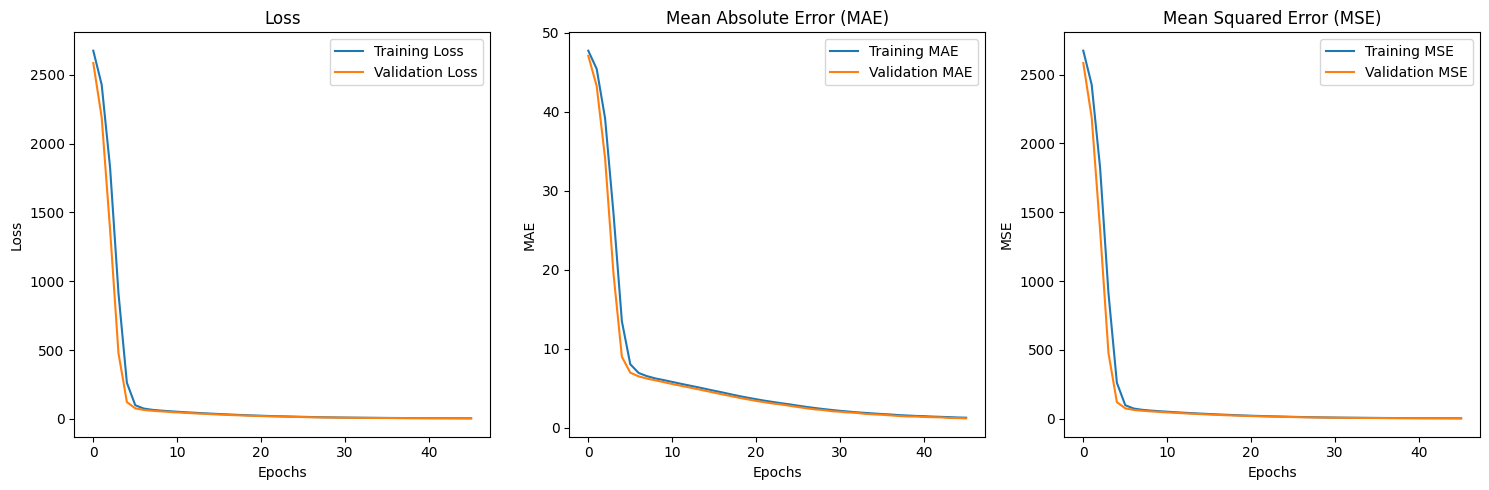

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Prediksi AQI pada data uji
y_pred = model.predict(X_test)

# Membuat DataFrame untuk membandingkan hasil prediksi dengan nilai aktual
results = pd.DataFrame({
    'Actual AQI': y_test.values,
    'Predicted AQI': y_pred.flatten()
})

# Tampilkan hasil prediksi
results.head(10)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Actual AQI,Predicted AQI
0,33,33.305344
1,86,85.053322
2,37,37.310127
3,23,22.359255
4,39,42.335121
5,39,40.404350
6,67,66.094963
7,31,31.371738
8,37,38.092735
9,38,40.416313


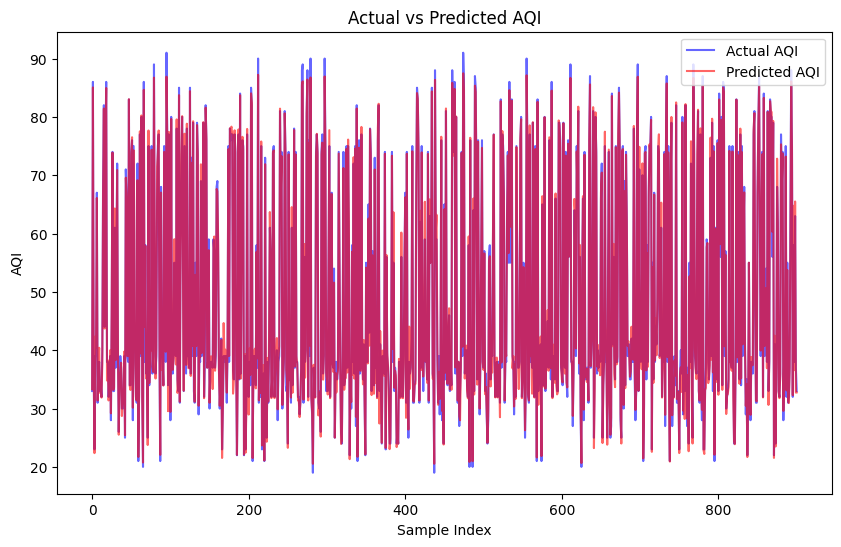

In [14]:
# Visualisasi perbandingan AQI aktual dan prediksi
plt.figure(figsize=(10, 6))
plt.plot(results['Actual AQI'], label='Actual AQI', color='blue', alpha=0.6)
plt.plot(results['Predicted AQI'], label='Predicted AQI', color='red', alpha=0.6)
plt.title('Actual vs Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI')
plt.legend()
plt.show()